In [1]:
import numpy as np

import matplotlib.pyplot as plt

import scipy.signal as signal

from scipy.signal import savgol_filter, find_peaks
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

from scipy.io import loadmat 
import glob , os




# --------- File loading and preprocessing ---------

# Path to filtered respiration data files and list of bad channels
filename = r"C:\Users\emire\OneDrive\Desktop\resp\Pig\Pig1\SignalsCSV\EndoPacingSite-LV-Apex.csv"
matfilename = r"C:\Users\emire\OneDrive\Desktop\resp\Pig\Pig1\Signals_Beats\EndoPacingSite-LV-Apex_Signal_select_Beat.mat"

# Load the filtered signal from CSV and transpose it


ModuleNotFoundError: No module named 'sklearn'

In [150]:
mat_data = loadmat(matfilename)
mat_data = mat_data['Signal_select_Beat']

QRSonset = mat_data[0][0][0] #Majik(magic) numbers I know but it is to acces the data which is alyas structered this way
QRSonset = QRSonset.flatten()
QRSrange = mat_data[0][0][2][0][0]


df = pd.read_csv(filename, sep=',')
df = df.T  # Rows become channels, columns become time samples

# List of bad leads (channels to exclude from analysis)
#Badlead_Ve = [1,15,	16,	25,	46,	53,	71,	72,	74,	78,	84,	96,	97, 105, 152, 153,]

# Remove bad leads from the dataframe
#df.drop(Badlead_Ve, axis=1, inplace=True)

# Create a time vector assuming a sampling rate of 2048 Hz
time = np.linspace(0, df[0].size / 2048, df[0].size)




min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
sampling_rate = 2048.0     # Sampling rate in Hz


In [151]:

peak_counts = []
ecgleads = []

# Loop over all leads (columns)
for lead in df.columns:
    y = df[lead][:].copy().to_numpy()  # Get the signal
    

    # Detect peaks
    peaks, _ = find_peaks(
    y, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(y)  # absouute minthreshold
    )

    troughs, _ = find_peaks(
    -y, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(y)  # absouute minthreshold
    )
    if(len(peaks)>2 and len(troughs)>0):
        # Ensure the signal starts with a low peak (trough)
        if troughs[0] > peaks[0]:  
            peaks = peaks[1:]  # Remove first high peak if it occurs before the first trough

        # Ensure the signal ends with a high peak
        if troughs[-1] > peaks[-1]:

            troughs = troughs[:-1]  # Remove last low peak if it occurs after the last high peak

    if True :#(len(peaks)>2 and len(troughs)>2):
    # Store number of detected peaks
        peak_counts.append(len(peaks))
        ecgleads.append(y)
    # Find the index of the lead with median number of peaks
median_index = np.argsort(peak_counts)[(len(peak_counts)*2// 3)]
median_ecg_signal = ecgleads[median_index]

print(len(peaks))

    

    
n_ecg = df.columns[median_index]

y = df[n_ecg][:].copy().to_numpy()  # Get the signal


# Detect peaks
peaks, _ = find_peaks(
y, 
prominence=0.1, 
distance=min_distance_qrs_ms / 1000 * sampling_rate,
height=0.4 * np.max(y)  # absouute minthreshold
)

troughs, _ = find_peaks(
-y, 
prominence=0.1, 
distance=min_distance_qrs_ms / 1000 * sampling_rate,
height=0.4 * np.max(y)  # absouute minthreshold
)
    # Ensure the signal starts with a low peak (trough)
if(len(peaks)>2 and len(troughs)>0):
    # Ensure the signal starts with a low peak (trough)
    if troughs[0] > peaks[0]:  
        peaks = peaks[1:]  # Remove first high peak if it occurs before the first trough

    # Ensure the signal ends with a high peak
    if troughs[-1] > peaks[-1]:

        troughs = troughs[:-1]  # Remove last low peak if it occurs after the last high peak


22


In [152]:

print(QRSonset)


[ 1515  2335  3154  3974  4792  5612  6430  7249  8068  8888  9706 10527
 11345 12165 12983 13803 14621 15440 16259 17079]


C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\3558069654.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_low_local_peaks], x[time_low_local_peaks], "o")  # Troughs
C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\3558069654.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_high_local_peaks], x[time_high_local_peaks], "x")  # Peaks


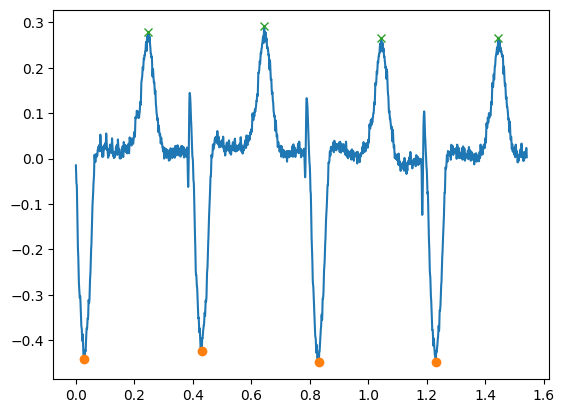

[ 508 1318 2137 2956]


In [153]:
x = df[n_ecg][(QRSonset[0]):(QRSonset[0] + QRSrange+3000)-1].copy()  # Make a copy of part of the signal for processing 
time = np.linspace(0, x.size / 2048, x.size)
# Define parameters for peak detection
min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
sampling_rate = 2048.0     # Sampling rate in Hz

# Detect negative peaks (likely R-troughs in ECG) with minimum prominence and spacing
time_low_local_peaks, _ = find_peaks(
    -x, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

# Detect positive peaks (likely R-peaks in ECG)
time_high_local_peaks, _ = find_peaks(
    x, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

plt.plot(time, x)  # Raw signal
plt.plot(time[time_low_local_peaks], x[time_low_local_peaks], "o")  # Troughs
plt.plot(time[time_high_local_peaks], x[time_high_local_peaks], "x")  # Peaks
plt.show()
print(time_high_local_peaks)

C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\3980479513.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_low_local_peaks], x[time_low_local_peaks], "o")  # Troughs
C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\3980479513.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_high_local_peaks], x[time_high_local_peaks], "x")  # Peaks


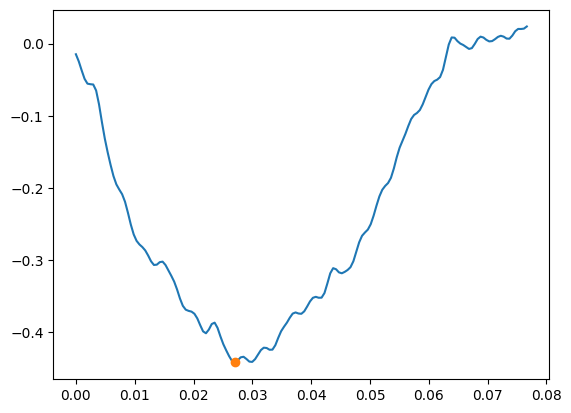

[]


In [154]:
x = df[n_ecg][(QRSonset[0]):(QRSonset[0] + QRSrange)-1].copy()  # Make a copy of part of the signal for processing 
time = np.linspace(0, x.size / 2048, x.size)
# Define parameters for peak detection
min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
sampling_rate = 2048.0     # Sampling rate in Hz

# Detect negative peaks (likely R-troughs in ECG) with minimum prominence and spacing
time_low_local_peaks, _ = find_peaks(
    -x, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

# Detect positive peaks (likely R-peaks in ECG)
time_high_local_peaks, _ = find_peaks(
    x, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

plt.plot(time, x)  # Raw signal
plt.plot(time[time_low_local_peaks], x[time_low_local_peaks], "o")  # Troughs
plt.plot(time[time_high_local_peaks], x[time_high_local_peaks], "x")  # Peaks
plt.show()
print(time_high_local_peaks)

C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\2319105620.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[newQRSOnset], x[newQRSOnset], "o")  # QRSonsetnew
C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\2319105620.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[QRSonset], x[QRSonset], "^")  # Troughs
C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_26888\2319105620.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

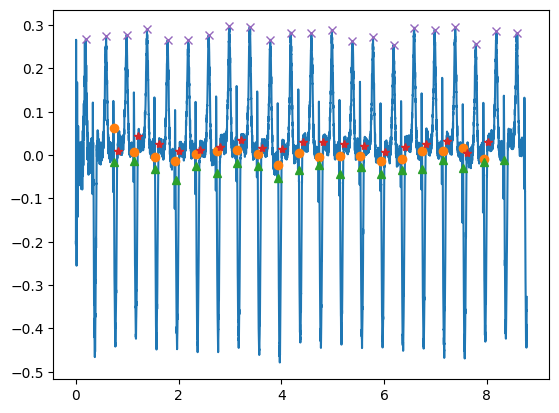

In [163]:
if (abs(min(x))>abs(max(x))):
    peakoffset = time_low_local_peaks[0]+10
    newQRSOnset = troughs - peakoffset
else:
    peakoffset = time_high_local_peaks[0]+10
    newQRSOnset = peaks - peakoffset

newQRSOnset = newQRSOnset[2:-1]

x = df[n_ecg][:].copy() 
time = np.linspace(0, x.size / 2048, x.size)
plt.plot(time, x)  # Raw signal
plt.plot(time[newQRSOnset], x[newQRSOnset], "o")  # QRSonsetnew
plt.plot(time[QRSonset], x[QRSonset], "^")  # Troughs
plt.plot(time[newQRSOnset+QRSrange], x[newQRSOnset+QRSrange], "*")  # Troughs
plt.plot(time[peaks], x[peaks], "x")  # Peaks
plt.show()


In [166]:
def find_csv_mat_pairs(base_path):
    signals_csv_folder = os.path.join(base_path, "SignalsCSV")
    signals_beats_folder = os.path.join(base_path, "Signals_Beats")

    # Find all CSV files
    csv_files = glob.glob(os.path.join(signals_csv_folder, "*.csv"))

    pairs = []

    for csv_path in csv_files:
        # Get base name without extension
        csv_name = os.path.splitext(os.path.basename(csv_path))[0]
        
        # Expected .mat file name
        mat_name = f"{csv_name}_Signal_select_Beat.mat"
        mat_path = os.path.join(signals_beats_folder, mat_name)

        if os.path.exists(mat_path):
            pairs.append((csv_path, mat_path))
        else:
            print(f"[!] Missing .mat file for: {csv_name}")

    return pairs



In [167]:
base_folder = r"C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig1"
pairs = find_csv_mat_pairs(base_folder)

print(f"\n✅ Found {len(pairs)} matched pairs:")
for csv_file, mat_file in pairs:
    print(f"CSV: {os.path.basename(csv_file)}")
    print(f"MAT: {os.path.basename(mat_file)}\n")



✅ Found 11 matched pairs:
CSV: EndoPacingSite-LV-Apex.csv
MAT: EndoPacingSite-LV-Apex_Signal_select_Beat.mat

CSV: EndoPacingSite-LV-Base.csv
MAT: EndoPacingSite-LV-Base_Signal_select_Beat.mat

CSV: EndoPacingSite-RV-Apex.csv
MAT: EndoPacingSite-RV-Apex_Signal_select_Beat.mat

CSV: EndoPacingSite-RV-Septum.csv
MAT: EndoPacingSite-RV-Septum_Signal_select_Beat.mat

CSV: EpiPacingSite-133.csv
MAT: EpiPacingSite-133_Signal_select_Beat.mat

CSV: EpiPacingSite-159.csv
MAT: EpiPacingSite-159_Signal_select_Beat.mat

CSV: EpiPacingSite-2.csv
MAT: EpiPacingSite-2_Signal_select_Beat.mat

CSV: EpiPacingSite-223.csv
MAT: EpiPacingSite-223_Signal_select_Beat.mat

CSV: EpiPacingSite-29.csv
MAT: EpiPacingSite-29_Signal_select_Beat.mat

CSV: EpiPacingSite-30.csv
MAT: EpiPacingSite-30_Signal_select_Beat.mat

CSV: Sinus.csv
MAT: Sinus_Signal_select_Beat.mat

